# BERTOPIC - NPS DATA - Passive

## Load libraries and initial config

In [1]:
### Importing necessary libraries/packages
import numpy as np
import pandas as pd
import scipy as scs
import os
import datetime as dt
import re
from pprint import pprint
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
pd.set_option("display.max_columns", 50, "display.max_rows", 100)

### For authentication
from google.cloud import bigquery
from google.colab import auth

### For data preprocessing
!pip install contractions
import nltk
import string
#stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
#tokenizer
from nltk.tokenize import RegexpTokenizer
#lemmatizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
#Stemmer
from nltk.stem.porter import PorterStemmer
#contractions
import contractions
#gensims
import gensim
from gensim import models
from gensim.utils import simple_preprocess

### For build and fine-tune BERT models
!pip install bertopic
from bertopic import BERTopic
#!pip install joblib==1.1.0
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load the NPS Data

In [2]:
### Authentication
auth.authenticate_user()
proj_name = 'pg-duke-student-capstone-v1'
proj_num = '545682952716'
proj_id =   'pg-duke-student-capstone-v1'
client = bigquery.Client(project=proj_id)

In [3]:
### Query cleaned nps data

sql = """
    WITH A AS
      (SELECT * FROM `pg-duke-student-capstone-v1.final_merged.clean_nps`)
      SELECT * FROM A
"""

# Run a Standard SQL query with the project set explicitly
project_id = 'pg-duke-student-capstone-v1'
data = pd.read_gbq(sql, project_id=proj_id, dialect='standard')
data.head()

,int64_field_0,application_id,product_type,respondent_id,survey_key,created_at,score,zendesk_ticket_id,medium,verbatim,analytics_user_id,analytics_user_id_1,gender,state_code,individual_income,age,marketing_application_source,first_touch_device,bmi,num_conditions,history_of_tobacco_use,marital_status,segment,segment_description
0,905,1273719.0,homeandauto,962841204,KEv4iDf9fOwFkrqGJ3dG78E3FXmoEjs5,2021-10-04 14:04:10+00:00,10,None,None,Listen to problems,1ae9467c575a4697bd99382cb7901979,1ae9467c575a4697bd99382cb7901979,male,None,NaN,77.0,Direct,Desktop,NaN,0.0,<NA>,divorced,NaN,None
1,1380,428727.0,homeandauto,669663712,a9CaYMZQJ6YAxihgHTyWSD1DhpTxGb9I,2020-07-24 14:09:47+00:00,8,None,None,My experience with Policy genius was great and...,6dfe7167d4c741cca83826dc5b22c580,6dfe7167d4c741cca83826dc5b22c580,female,None,NaN,37.0,Direct,Desktop,NaN,0.0,<NA>,None,NaN,None
2,1389,841048.0,homeandauto,850431113,o9BFKWnnOducRd4AjQcETyjbHbTj0xQb,2021-04-02 16:57:16+00:00,9,None,None,Working with you was fast and easy and I like ...,2f359d6cde594f309b0989e96ce2454f,2f359d6cde594f309b0989e96ce2454f,male,WI,NaN,56.0,Direct,Desktop,NaN,0.0,<NA>,single,NaN,None
3,1398,1454888.0,homeandauto,1047155544,BHUlqVZW1c5am64nlz3rXnnJop68iqXS,2022-01-06 13:03:58+00:00,10,None,None,My agent was very informed and help make the p...,052feaa8c2a14c94953481e4c0567dd3,052feaa8c2a14c94953481e4c0567dd3,male,CA,NaN,28.0,Direct,Desktop,NaN,0.0,<NA>,married,NaN,None
4,1419,1544133.0,homeandauto,1075912288,qSi8fsNFAjS3atrE54cmsd52Mec8gsmP,2022-02-17 11:47:16+00:00,10,None,None,I got my insurance for both vehicles cut in ha...,653fc046465e40dc8b3b0f73a17bdcfd,653fc046465e40dc8b3b0f73a17bdcfd,male,LA,NaN,35.0,Direct,Desktop,NaN,0.0,<NA>,married,NaN,None


In [4]:
### Look at dimensions of the data
print(data.shape)

(13261, 24)


In [5]:
### Quick browse of customer reviews
data["verbatim"]

0                                      Listen to problems 
1        My experience with Policy genius was great and...
2        Working with you was fast and easy and I like ...
3        My agent was very informed and help make the p...
4        I got my insurance for both vehicles cut in ha...
                               ...                        
13256       Quickly response with appropriate information 
13257                      very easy and friendly process!
13258    Better rate than anyone. Great customer servic...
13259    Everyone I worked with was very professional, ...
13260    Great overall experience, very easy getting my...
Name: verbatim, Length: 13261, dtype: object

In [6]:
### Clean Missingness
data = data[~data["verbatim"].astype(str).eq('None')]
data = data.dropna(subset=["verbatim"], axis=0)

# display the updated DataFrame
print(data.shape)
### RES: No missingness

(13261, 24)


In [7]:
### Converting the timestamps to day, month and year for later use
data = data.rename(columns={'created_at': 'response_timestamp'})
data['date'] = pd.to_datetime(data['response_timestamp'])
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data["year-month"] =data.year.astype(str) + "-" + data.month.astype(str)

In [8]:
### Create a variable for customer segments by the score
data["score_categorized"] = pd.cut(data.score, bins=[-np.inf, 6, 8, 10],
                  labels=["detractor", "passive", "promoter"])

In [9]:
### Check data to see the changes made above
data.head(2)

,int64_field_0,application_id,product_type,respondent_id,survey_key,response_timestamp,score,zendesk_ticket_id,medium,verbatim,analytics_user_id,analytics_user_id_1,gender,state_code,individual_income,age,marketing_application_source,first_touch_device,bmi,num_conditions,history_of_tobacco_use,marital_status,segment,segment_description,date,day,month,year,year-month,score_categorized
0,905,1273719.0,homeandauto,962841204,KEv4iDf9fOwFkrqGJ3dG78E3FXmoEjs5,2021-10-04 14:04:10+00:00,10,None,None,Listen to problems,1ae9467c575a4697bd99382cb7901979,1ae9467c575a4697bd99382cb7901979,male,None,NaN,77.0,Direct,Desktop,NaN,0.0,<NA>,divorced,NaN,None,2021-10-04 14:04:10+00:00,4,10,2021,2021-10,promoter
1,1380,428727.0,homeandauto,669663712,a9CaYMZQJ6YAxihgHTyWSD1DhpTxGb9I,2020-07-24 14:09:47+00:00,8,None,None,My experience with Policy genius was great and...,6dfe7167d4c741cca83826dc5b22c580,6dfe7167d4c741cca83826dc5b22c580,female,None,NaN,37.0,Direct,Desktop,NaN,0.0,<NA>,None,NaN,None,2020-07-24 14:09:47+00:00,24,7,2020,2020-7,passive


In [10]:
### Check distribution of scores 
data["score"].value_counts()

10    9808
9     1443
8      810
7      320
0      246
5      194
6      157
3       88
2       73
4       66
1       56
Name: score, dtype: Int64

In [11]:
### Check distribution of segments 
data['score_categorized'].value_counts()

promoter     11251
passive       1130
detractor      880
Name: score_categorized, dtype: int64

## Data Preprocessing

### Create Passive Data

In [12]:
### Subset the passive data
passive_data = data[data['score_categorized']=="passive"]
passive_data.shape

(1130, 30)

In [13]:
### Check the summary of the passive data
passive_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1130 entries, 1 to 13179
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   int64_field_0                 1130 non-null   Int64              
 1   application_id                1130 non-null   float64            
 2   product_type                  1130 non-null   object             
 3   respondent_id                 1130 non-null   Int64              
 4   survey_key                    1130 non-null   object             
 5   response_timestamp            1130 non-null   datetime64[ns, UTC]
 6   score                         1130 non-null   Int64              
 7   zendesk_ticket_id             101 non-null    object             
 8   medium                        101 non-null    object             
 9   verbatim                      1130 non-null   object             
 10  analytics_user_id             1119 

In [14]:
### Check the yearly distribuion
passive_data.year.value_counts()

2020    310
2021    293
2019    187
2022    159
2018    114
2017     67
Name: year, dtype: int64

### Preprocessing

In [15]:
### Data Preprocessing Helper Function

stop_words = stopwords.words('english')

stop_words.extend(['from', 'subject', 'use', 'policygenius', 'policy', 'genius','insurance', "pg", 'none', 'na', "able", "already", "also",
                   "was", "were", "thus", "although", "always", "bc", "because", "definitely", "could", "couldnt", 'would', "wouldnt"])

def preprocess(text_col):
    """This function will apply NLP preprocessing lambda functions over a pandas series such as df['text'].
       These functions include converting text to lowercase, removing emojis, expanding contractions, removing punctuation,
       removing numbers, removing stopwords, lemmatization, etc."""
    
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split('/')]))
    
    # remove emojis
    #text_col = text_col.apply(lambda x: demoji.replace(x, ""))
    
    # expand contractions  
    text_col = text_col.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

    # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    stopwords = [sw for sw in stop_words if sw not in ['not', 'no']]
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

    # lemmatization
    text_col = text_col.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(w) for w in x.split()]))

    # stemming
    #from nltk.stem import PorterStemmer
    #text_col = text_col.apply(lambda x: ' '.join([PorterStemmer().stem(w) for w in x.split()]))

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) >= 3]))

    return text_col

In [16]:
### view one instance
passive_data["verbatim"][1]

'My experience with Policy genius was great and easy. '

In [17]:
### Calling the data preprocessing function above and visualizing same instance as above to compare
passive_clean = preprocess(passive_data["verbatim"])
passive_clean[1]

'experience great easy'

In [18]:
### Quick check through the data we are using
passive_clean.head()

1                                 experience great easy
15    talking another guy ghdn got message not reali...
30                                            good rate
37                          good price really busy team
45                                         good company
Name: verbatim, dtype: object

In [19]:
### Total review data
len(passive_clean)

1130

In [20]:
### merge the clean comments into the dataset
passive_data["comments_clean"] = passive_clean

In [21]:
### BERTopic requires data in an array format. We convert the data frame texts into a numpy array object.
passive_clean_input = np.array(passive_clean)   
passive_clean_input 

### This is the finalized data that will be inputed into the model

array(['experience great easy',
       'talking another guy ghdn got message not realize not company got mail poljcy grnius get name',
       'good rate', ..., 'great customer service',
       'easy process great customer service',
       'ease convenience coupled competitive pricing'], dtype=object)

In [22]:
### Quick check that the length of data is maintained
len(passive_clean_input)

1130

## Fine-tune parameters


**Parameters of BERTopic Algorithm**


*   BERTopic
> 1.   `top_n_words`: the number of words per topic that you want to be extracted. The more words you put in a topic the less coherent it can become (Recommend between 10-20)
> 2.   `min_topic_size`: the minimum size of a topic. The lower this value the more topics are created
> 3.   `nr_topic`: the final number of topics. If specifies, after training the model, the number of topics will be reduced to it. If not, no reduction is applied and use "auto" to automatically reduce topics using HDBSCAN

 
*   UMAP
> 1.   `n_neighbors`: the number of neighboring sample points used when making the manifold approximation. Increasing this value typically results in a more global view of the embedding structure and results in larger clusters being created (Default: 15)
> 2.   `n_components`: the dimensionality of the embeddings after reducing them.Will largely affect the performance of HDBSCAN. (Default: 5)


*   HDBSCAN
> 1.   `min_cluster_size`: the number of clusters that will be generated (Default: 10) (Recommend: increase it)
> 2. `min_samples`: (automatically set to `min_cluster_size`) controls the number of outliers generated




**Coherence score**

Coherence score is a metric used to evaluate the coherence of a text, such as a topic model or a document clustering algorithm. It measures how semantically similar the words in a text are to each other, and how well they form meaningful topics or clusters. Its thresholds are subjective and can vary depending on the domain, the size of the corpus, the type of the topic modeling algorithm, and other factors. However, there are some general rule-of-thumb guidelines for interpreting coherence scores in topic modeling:

* Low coherence score: < 0.4 -- the generated topics are not very interpretable or useful for downstream tasks.

* Moderate coherence score: 0.4 ~ 0.6 -- the generated topics are somewhat interpretable and may be useful for some downstream tasks.

* High coherence score: > 0.6 -- the generated topics are highly interpretable and useful for downstream tasks.

It's important to note that these are rough guidelines, and the interpretation of coherence scores depends on many factors. For example, coherence scores tend to be lower for larger corpora, as there are more potential word co-occurrences that may not be semantically related. Additionally, coherence scores are not the only metric to consider when evaluating the quality of topic models; other factors, such as topic diversity, specificity, and relevance to the domain, should also be taken into account.

In [23]:
### Helpfer Function of the Evaluation Metric: Coherence Score
def coherence_bert(bert_model, topics, df):
  # Preprocess Documents
  documents = pd.DataFrame({"Document": df,
                            "ID": range(len(df)),
                            "Topic": topics})
  documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document':' '.join})
  cleaned_docs = bert_model._preprocess_text(documents_per_topic.Document.values)

  # Extract vectorizer and analyzer from BERTopic
  vectorizer = bert_model.vectorizer_model
  analyzer = vectorizer.build_analyzer()

  # Extract features for Topic Coherence evaluation
  words = vectorizer.get_feature_names_out()
  tokens = [analyzer(doc) for doc in cleaned_docs]
  dictionary = corpora.Dictionary(tokens)
  corpus = [dictionary.doc2bow(token) for token in tokens]
  topic_words = [[words for words, _ in bert_model.get_topic(topic)] for topic in range(len(set(topics))-1)]

  # Removing any empty strings
  topic_words = [[x for x in sub_arr if x not in ('', None)] for sub_arr in topic_words]
  topic_words

  # Calculate coherence score
  coherence_model = CoherenceModel(topics=topic_words,
                                   texts=tokens,
                                   corpus=corpus,
                                   dictionary=dictionary,
                                   coherence='c_v')
  coherence = coherence_model.get_coherence()
  return(coherence)

In [24]:
### Pre-specify models without parameters to be tuned

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 4 - Tokenize topics and create ngrams
vectorizer_model = CountVectorizer(stop_words="english", ngram_range= (2, 3))

# Step 5 - Create topic representation 
ctfidf_model = ClassTfidfTransformer()

In [25]:
### parameters grid
umap_n_neighbors = [10, 15, 20]
umap_n_components = [3, 5, 8]
hdbscan_min_cluster_size = [10, 15]
bert_min_topic_size = [10, 15]
bert_top_n_words = [10, 15]
bert_nr_topics = [5, 6, 7, 8]

In [26]:
res = []
for a in umap_n_neighbors:
  for b in umap_n_components:
    for c in hdbscan_min_cluster_size:
      for d in bert_min_topic_size:
        for e in bert_top_n_words: 
          for f in bert_nr_topics:
            # Step 2 - Reduce dimensionality
            umap_model = UMAP(random_state = 2023, min_dist=0.0, metric='cosine',
                              n_neighbors = a, n_components = b)
            # Step 3 - Cluster reduced embeddings
            hdbscan_model = HDBSCAN(min_cluster_size= c,
                                    metric='euclidean', cluster_selection_method='eom',
                                    prediction_data = True)
            # BERT Model
            bert_model = BERTopic(min_topic_size = d, top_n_words = e, nr_topics = f,
                embedding_model=embedding_model, umap_model=umap_model,
                hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model,
                ctfidf_model=ctfidf_model, verbose = False)
            topics, probs = bert_model.fit_transform(passive_clean_input)
            # Visualization
            #cluster_fig = bert_model.visualize_topics()
            #topic_fig =  bert_model.visualize_barchart(n_words =10, width = 300, height = 400)
            # Coherence
            coherence = coherence_bert(bert_model, topics, passive_clean_input)

            # Restore
            res.append({'umap_n_neighbors':a, 'umap_n_components':b, 'hdbscan_min_cluster_size': c,
                        'bert_min_topic_size': d, 'bert_top_n_words': e, 'bert_nr_topics': f,
                        #'cluster_fig': cluster_fig, 'topic_fig': topic_fig,
                        'coherence': coherence})
# WARNING: Take a relatively long time (about 2h 5min) to run for passive data

In [61]:
### Browse the result of fine-tuning
tuning_df = pd.DataFrame(res)
(tuning_df.sort_values(by = ["coherence", "bert_nr_topics"], ascending = False)
 .loc[(tuning_df['coherence'] >= 0.6) & (tuning_df['umap_n_neighbors']!=20)]
 .drop_duplicates("coherence")
 .head(10)
)

### when umap_n_neighbors = 20, the UMAP matrix is not sparse

,umap_n_neighbors,umap_n_components,hdbscan_min_cluster_size,bert_min_topic_size,bert_top_n_words,bert_nr_topics,coherence
0,10,3,10,10,10,5,0.877936
1,10,3,10,10,10,6,0.822714
96,15,3,10,10,10,5,0.813409
2,10,3,10,10,10,7,0.795297
68,10,8,10,10,15,5,0.785356
65,10,8,10,10,10,6,0.776603
160,15,8,10,10,10,5,0.773275
37,10,5,10,10,15,6,0.765930
36,10,5,10,10,15,5,0.765309
66,10,8,10,10,10,7,0.760570


Besides coherence score, we need to take other aspects of model performance into account. This include:

* Extracted topics make semantic sense ---- by Word distribution plot
* Separability of topics ---- by the Inter-topic map
* Raw comments

Therefore, I tried several top-rated models below to select the best model to use for passive customers
 

#### Model 1: No. 0-2 
Only generate 5 topics, and one of them does not make sense

In [29]:
best_mdl1 = BERTopic(
    embedding_model = embedding_model, 
    umap_model = UMAP(random_state = 2023, min_dist=0.0, metric='cosine',
                    n_neighbors = 10, n_components = 3),
    hdbscan_model = HDBSCAN(min_cluster_size= 10, metric='euclidean', 
                            cluster_selection_method='eom', prediction_data = True), 
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model, 
    min_topic_size = 10, top_n_words = 10, nr_topics = 5,
    verbose = False
)
topics, probs = best_mdl1.fit_transform(passive_clean_input)

In [30]:
best_mdl1.visualize_topics()

In [31]:
best_mdl1.visualize_barchart(n_words =10, width = 300, height = 400, top_n_topics = 20)

In [113]:
best_mdl1.get_representative_docs(topic=2)

['', '', 'not thanks']

#### Model 2: No.96

In [107]:
best_mdl2 = BERTopic(
    embedding_model = embedding_model, 
    umap_model = UMAP(random_state = 2023, min_dist=0.0, metric='cosine',
                      n_neighbors = 15, n_components = 3),
    hdbscan_model = HDBSCAN(min_cluster_size= 10, metric='euclidean', 
                            cluster_selection_method='eom', prediction_data = True), 
    vectorizer_model=vectorizer_model,
    min_topic_size = 10, top_n_words = 10, nr_topics = 5,
    ctfidf_model=ctfidf_model, 
    verbose = False
)
topics, probs = best_mdl2.fit_transform(passive_clean_input)

In [67]:
best_mdl2.visualize_topics()

In [64]:
best_mdl2.visualize_distribution(probabilities=probs)

In [65]:
best_mdl2.visualize_barchart(n_words =10, width = 300, height = 400)

In [66]:
best_mdl2.get_representative_docs()

{-1: ['life industry sale process annoying inefficient help understanding price company like imagine company requires make decision quickly within week get quote company take week confirmed premium valid least month senior executive company realize team harass applicant phone call email make company look bad therefore gracious giving instead ultimately selecting company pacific life item went decision process price viability life company consumer complaint company helpful help instead',
  'received several email needed sign application sent docusign not receiving end several email chatting different rep one tried help another wanted call phone number getting frustrated treated like stupid like something wrong discovered signed everything problem end explanation got system not alert signed application hope future check client sends back email documentation sent gone treating potential client like idiot upset speaking second rep thru chat trying reach person handling case not understand 

In [108]:
### Check topic distribution
best_mdl2.get_document_info(passive_clean_input).groupby("Topic").size()

Topic
-1    378
 0    647
 1     58
 2     34
 3     13
dtype: int64

In [109]:
### Create a temp df to see some sample raw comments
temp = pd.DataFrame({'topic': topics, 'doc_cleaned': passive_clean_input, 'doc_raw': passive_data["verbatim"], 
                            'year': passive_data['year'],
                            'year-month': passive_data['year-month']})

In [110]:
temp.doc_raw[temp["topic"]==2]

60       The preliminary estimates were not truly repre...
585      Easy to use for life insurance, but slow to re...
799      Initial choice of provider is not transparent....
884      Auto rates were high and I feel like I found s...
930      To me an 8 is a solid score, but the inability...
1159     I was hoping to find a number of different opt...
1264     The process was pretty painless (as painless a...
2194     The staff was helpful and friendly. The main r...
2961     I think it was helpful but I also found a chea...
3921     Was very easy and Ashely was very helpful, kno...
4074     Found best price on home insurance but not aut...
4079     Not easy to obtain info on the full list of in...
4371     The first two people I contacted were not able...
4520     My home insurance increased for no reason.  I ...
4556     I am not familiar with your company or the one...
4971     I am over 65,and was applying for term insuran...
5571     I felt like I was pushed hard to get more cove.

In [122]:
temp.doc_raw[temp["topic"]==2][6878]

"I provided my current auto policy and coverage.  Policy genius didn't tell me that my current policy was cheaper than I could get with a bundled discount.  Had I not spent the time of splitting the home policy from the auto policy I would have overpaid by ~600$ per year."

#### Model 3: No.68
One of the topic does not make sense

In [56]:
best_mdl3 = BERTopic(
    embedding_model = embedding_model, 
    umap_model = UMAP(random_state = 2023, min_dist=0.0, metric='cosine',
                      n_neighbors = 10, n_components = 8),
    hdbscan_model = HDBSCAN(min_cluster_size= 10, metric='euclidean', 
                            cluster_selection_method='eom', prediction_data = True), 
    vectorizer_model=vectorizer_model,
    min_topic_size = 10, top_n_words = 15, nr_topics = 5,
    ctfidf_model=ctfidf_model, 
    verbose = False
)
topics, probs = best_mdl3.fit_transform(passive_clean_input)

In [57]:
best_mdl3.visualize_topics()

In [58]:
best_mdl3.visualize_barchart(n_words =10, width = 300, height = 400)

In [59]:
best_mdl3.get_representative_docs()

{-1: ['life industry sale process annoying inefficient help understanding price company like imagine company requires make decision quickly within week get quote company take week confirmed premium valid least month senior executive company realize team harass applicant phone call email make company look bad therefore gracious giving instead ultimately selecting company pacific life item went decision process price viability life company consumer complaint company helpful help instead',
  'quick efficient friendly informative responsive service rate par quote got couple thing initially quoted rate told quick turnaround time without exam called back agent talked said not eligible due agethough first agent knew age process ended taking literally month start finish medical record review initially quoted rate best health level changed medical record review wish better informed premium range shock learn large jump premium seemed minor issue brought level level',
  'liked ability compare quo

#### Model 4: No.65 & 66

In [103]:
best_mdl4 = BERTopic(
    embedding_model = embedding_model, 
    umap_model = UMAP(random_state = 2023, min_dist=0.0, metric='cosine',
                    n_neighbors = 10, n_components = 8),
    hdbscan_model = HDBSCAN(min_cluster_size= 10, metric='euclidean', 
                            cluster_selection_method='eom', prediction_data = True), 
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model, 
    min_topic_size = 10, top_n_words = 10, nr_topics = 6,
    verbose = False
)
topics, probs = best_mdl4.fit_transform(passive_clean_input)

In [101]:
best_mdl4.visualize_topics()

In [102]:
best_mdl4.visualize_barchart(n_words =10, width = 300, height = 400)

In [98]:
best_mdl4.get_representative_docs()

{-1: ['life industry sale process annoying inefficient help understanding price company like imagine company requires make decision quickly within week get quote company take week confirmed premium valid least month senior executive company realize team harass applicant phone call email make company look bad therefore gracious giving instead ultimately selecting company pacific life item went decision process price viability life company consumer complaint company helpful help instead',
  'quick efficient friendly informative responsive service rate par quote got couple thing initially quoted rate told quick turnaround time without exam called back agent talked said not eligible due agethough first agent knew age process ended taking literally month start finish medical record review initially quoted rate best health level changed medical record review wish better informed premium range shock learn large jump premium seemed minor issue brought level level',
  'liked ability compare quo

In [99]:
### Check topic distribution
best_mdl4.get_document_info(passive_clean_input).groupby("Topic").size()

Topic
-1    336
 0    635
 1     70
 2     43
 3     33
 4     13
dtype: int64

In [104]:
### Create a temp df to see some sample raw comments
temp = pd.DataFrame({'topic': topics, 'doc_cleaned': passive_clean_input, 'doc_raw': passive_data["verbatim"], 
                            'year': passive_data['year'],
                            'year-month': passive_data['year-month']})

In [106]:
temp.doc_raw[temp["topic"]==3]

265                                                    N/a
1369                                     seems appropriate
1650                                        Good not great
2201                                                 Nada.
2333                                                   Yup
2568                                                  nope
4862                8 is good , ten is perfect , no one is
4874                                  Don't do 9 never 10s
4926                                         FAIRLY LIKELY
5110                                                   n/a
5235                                             Excellent
5999                                                     .
6104                                          They’re good
6183                                            8 is great
6752                                                    No
7042                                        Good but slow.
7763                     They just seem to be pretty goo

#### Model 5: No.160
Two topics are too close

In [72]:
best_mdl5 = BERTopic(
    embedding_model = embedding_model, 
    umap_model = UMAP(random_state = 2023, min_dist=0.0, metric='cosine',
                    n_neighbors = 15, n_components = 8),
    hdbscan_model = HDBSCAN(min_cluster_size= 10, metric='euclidean', 
                            cluster_selection_method='eom', prediction_data = True), 
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model, 
    min_topic_size = 10, top_n_words = 10, nr_topics = 5,
    verbose = False
)
topics, probs = best_mdl5.fit_transform(passive_clean_input)
best_mdl5.visualize_topics()

In [75]:
best_mdl5.visualize_barchart(n_words =10, width = 300, height = 400)

In [76]:
best_mdl5.get_representative_docs()

{-1: ['processed flowed well not perfectthere error made process caused step repeated amended someone forgetting mark box form fill mark later mark box not initial eform sent technology easily capability autofill information instead consumer repeatedly filling similar information setting cell first name fill first name given understand many form not changing save client good amount time taking information initially sent automating throughout save timeso overall good job excellent not perfect not find improvement thank great experience helping find great price',
  'quick efficient friendly informative responsive service rate par quote got couple thing initially quoted rate told quick turnaround time without exam called back agent talked said not eligible due agethough first agent knew age process ended taking literally month start finish medical record review initially quoted rate best health level changed medical record review wish better informed premium range shock learn large jump p

#### Model 6: No.36 & 37
One of the topic does not make sense

In [81]:
best_mdl6 = BERTopic(
    embedding_model = embedding_model, 
    umap_model = UMAP(random_state = 2023, min_dist=0.0, metric='cosine',
                    n_neighbors = 10, n_components = 5),
    hdbscan_model = HDBSCAN(min_cluster_size= 10, metric='euclidean', 
                            cluster_selection_method='eom', prediction_data = True), 
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model, 
    min_topic_size = 10, top_n_words = 15, nr_topics = 5,
    verbose = False
)
topics, probs = best_mdl6.fit_transform(passive_clean_input)

In [82]:
best_mdl6.visualize_topics()

In [83]:
best_mdl6.visualize_barchart(n_words =10, width = 300, height = 400)

In [80]:
best_mdl6.get_representative_docs()

{-1: ['life industry sale process annoying inefficient help understanding price company like imagine company requires make decision quickly within week get quote company take week confirmed premium valid least month senior executive company realize team harass applicant phone call email make company look bad therefore gracious giving instead ultimately selecting company pacific life item went decision process price viability life company consumer complaint company helpful help instead',
  'overall experience easy took lot work otherwise daunting process not like upselling originally wanted year term life upsold year not mind price time coverage made sense bothered went live got call guy guy phone questioned not get longer year guy upsold going try especially clear initial negotiation not want certain amount per month rubbed wrong way otherwise think really great service everyone spoke nice helpful thanks good experience',
  'processed flowed well not perfectthere error made process cau

#### **Recommendation: Model 2**

In [123]:
### Save the model checkpoint
best_mdl2.save("bertmdl_passive")

## BERTopic Model

In [124]:
### Load the saved model
passive_bert = BERTopic.load("bertmdl_passive") 

In [129]:
### save the information into a data frame
mdl_doc_df = pd.DataFrame({'topic': passive_bert.topics_, 
                           'doc_cleaned': passive_clean_input, 
                           'doc_raw': passive_data["verbatim"],
                           'year': passive_data['year'],
                           'year-month': passive_data['year-month']})
### topics comes from: topics, probs = bert_model.fit_transform(passive_clean_input)

In [130]:
### Check the dimension
len(mdl_doc_df)

1130

In [131]:
### Quick Browse the data
mdl_doc_df.head()

,topic,doc_cleaned,doc_raw,year,year-month
1,0,experience great easy,My experience with Policy genius was great and...,2020,2020-7
15,1,talking another guy ghdn got message not reali...,I was talking to another guy z as no ghdn got ...,2021,2021-4
30,0,good rate,Good rates.,2020,2020-8
37,0,good price really busy team,"Good price, but really busy team",2022,2022-7
45,0,good company,Good company,2022,2022-5


In [132]:
### Check the topic distribution
mdl_doc_df.topic.value_counts()
### Found large number of outliers (topic = -1)

 0    647
-1    378
 1     58
 2     34
 3     13
Name: topic, dtype: int64

In [133]:
### Check the raw comments of outliers
mdl_doc_df.doc_raw[mdl_doc_df["topic"]==-1]

61       There are many people that would not be comfor...
73                          Good for finding comparisons. 
101      Some things are good and some are not with com...
158      Process was very well managed. Choices present...
208          Got me a cheaper plan than compared to other.
                               ...                        
12978                              To much back and forth 
12982    The company is good but communication is dodgy...
13087    The process was good and less of an inconvenie...
13098    Time from beginning to end was longer than I e...
13179    Ease and convenience coupled with competitive ...
Name: doc_raw, Length: 378, dtype: object

### Reduce outliers (topic == -1)

In [135]:
### Reduce outliers
new_topics = passive_bert.reduce_outliers(passive_clean_input, topics)

In [136]:
### update the result data frame
mdl_doc_df_new = pd.DataFrame({'topic': new_topics, 'doc_cleaned': passive_clean_input, 'raw comment': passive_data["verbatim"], 
                            'year': passive_data['year'],
                            'year-month': passive_data['year-month']})
### topics comes from: passive_bert.reduce_outliers(passive_clean_input, topics)

In [137]:
### Quick browse
mdl_doc_df_new.head()

,topic,doc_cleaned,raw comment,year,year-month
1,0,experience great easy,My experience with Policy genius was great and...,2020,2020-7
15,1,talking another guy ghdn got message not reali...,I was talking to another guy z as no ghdn got ...,2021,2021-4
30,0,good rate,Good rates.,2020,2020-8
37,0,good price really busy team,"Good price, but really busy team",2022,2022-7
45,0,good company,Good company,2022,2022-5


In [138]:
### Check the topic distribution after outlier reduction
mdl_doc_df_new.topic.value_counts()
### RES: only 104/1130 outliers, less than 10%

 0    874
-1    104
 1     76
 2     53
 3     23
Name: topic, dtype: int64

## Result

### Read sample comments to summarize topics

In [296]:
mdl_doc_df_new[mdl_doc_df_new.topic == 3]["raw comment"].values

### Gather useful information and output final table

In [141]:
### Obtain information from 'get_document_info' feature of BERTopic model
doc_info = passive_bert.get_document_info(passive_clean_input)
doc_info.head()

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,experience great easy,0,0_customer service_process took_good experienc...,customer service - process took - good experie...,1.000000,False
1,talking another guy ghdn got message not reali...,1,1_text message_phone text_message email_text e...,text message - phone text - message email - te...,0.508997,False
2,good rate,0,0_customer service_process took_good experienc...,customer service - process took - good experie...,1.000000,False
3,good price really busy team,0,0_customer service_process took_good experienc...,customer service - process took - good experie...,1.000000,False
4,good company,0,0_customer service_process took_good experienc...,customer service - process took - good experie...,0.341539,False


In [142]:
doc_info.shape

(1130, 6)

In [297]:
doc_info[doc_info.Topic == -1]

**Note:**
The output of `get_document_info` still use the topics and top_n_words before updating (i.e. reducing the outliers). So, it has 378 records within topic 0 instead of 104. We need to replace them manully with new topics.

In [143]:
### Create a mapping table with 1-to-1 relationship between topic and top_n_words
topic_words_mapping = doc_info[["Topic", "Top_n_words"]].drop_duplicates().rename(columns={"Topic": "topic", "Top_n_words": "top_n_words"})

In [144]:
topic_words_mapping

,topic,top_n_words
0,0,customer service - process took - good experie...
1,1,text message - phone text - message email - te...
5,2,home auto - rate higher - home owner - current...
6,-1,customer service - application process - good ...
14,3,responsive great - helpful responsive - respon...


In [147]:
### Create the final output table with new topics after outlier reduction
passive_tbl = pd.DataFrame({'comment': passive_data.verbatim, 
                            'group': passive_data.score_categorized, 
                            'topic': new_topics, 
                            'date': passive_data.date})
passive_tbl.head()

,comment,group,topic,date
1,My experience with Policy genius was great and...,passive,0,2020-07-24 14:09:47+00:00
15,I was talking to another guy z as no ghdn got ...,passive,1,2021-04-30 08:57:04+00:00
30,Good rates.,passive,0,2020-08-25 12:55:36+00:00
37,"Good price, but really busy team",passive,0,2022-07-18 13:36:01+00:00
45,Good company,passive,0,2022-05-09 13:28:56+00:00


In [167]:
### Map the topics number with the corresponding top_n_words in passive_tbl by merging
passive_tbl = passive_tbl.merge(topic_words_mapping, how="left", on=["topic"])

In [169]:
### Check the mapping works correctly
passive_tbl.groupby(["topic", "top_n_words"]).count()

,,comment,group,date
topic,top_n_words,,,
-1,customer service - application process - good experience - took long - overall good - took month - long time - service great - overall good experience - easy process,104,104,104
0,customer service - process took - good experience - took long - took longer - long time - good service - easy process - longer expected - medical exam,874,874,874
1,text message - phone text - message email - text email - email phone - email text - phone number - email day - text message email - multiple time,76,76,76
2,home auto - rate higher - home owner - current coverage - auto coverage - different option - auto rate - person explain - acceptable life - pay credit score,53,53,53
3,responsive great - helpful responsive - responsive easy - accesible responsive - question overall - offered excellent support - responsive easy work - responsive easy responsive - responsive accesible responsive - responsive accesible,23,23,23


In [176]:
passive_tbl

,comment,group,topic,date,top_n_words
0,My experience with Policy genius was great and...,passive,0,2020-07-24 14:09:47+00:00,customer service - process took - good experie...
1,I was talking to another guy z as no ghdn got ...,passive,1,2021-04-30 08:57:04+00:00,text message - phone text - message email - te...
2,Good rates.,passive,0,2020-08-25 12:55:36+00:00,customer service - process took - good experie...
3,"Good price, but really busy team",passive,0,2022-07-18 13:36:01+00:00,customer service - process took - good experie...
4,Good company,passive,0,2022-05-09 13:28:56+00:00,customer service - process took - good experie...
...,...,...,...,...,...
1125,Time from beginning to end was longer than I e...,passive,0,2017-12-07 07:23:49+00:00,customer service - process took - good experie...
1126,"The process was fairly painless; however, I fo...",passive,0,2019-07-02 19:16:05+00:00,customer service - process took - good experie...
1127,great customer service,passive,0,2021-07-21 12:33:30+00:00,customer service - process took - good experie...
1128,Very easy process and great customer service,passive,0,2019-04-23 12:41:00+00:00,customer service - process took - good experie...


In [226]:
### Add a column of topic description
passive_tbl['topic_desc'] = 'Outlier'
passive_tbl.loc[passive_tbl['topic'] == 0, 'topic_desc'] = '0 - Overall Great Service but Long Process'
passive_tbl.loc[passive_tbl['topic'] == 1, 'topic_desc'] = '1 - Overcontact'
passive_tbl.loc[passive_tbl['topic'] == 2, 'topic_desc'] = '2 - Coverage & Quote'
passive_tbl.loc[passive_tbl['topic'] == 3, 'topic_desc'] = '3 - Responsive Representatives'

In [227]:
passive_tbl.head()

,comment,group,topic,date,top_n_words,topic_desc
0,My experience with Policy genius was great and...,passive,0,2020-07-24 14:09:47+00:00,customer service - process took - good experie...,0 - Overall Great Service but Long Process
1,I was talking to another guy z as no ghdn got ...,passive,1,2021-04-30 08:57:04+00:00,text message - phone text - message email - te...,1 - Overcontact
2,Good rates.,passive,0,2020-08-25 12:55:36+00:00,customer service - process took - good experie...,0 - Overall Great Service but Long Process
3,"Good price, but really busy team",passive,0,2022-07-18 13:36:01+00:00,customer service - process took - good experie...,0 - Overall Great Service but Long Process
4,Good company,passive,0,2022-05-09 13:28:56+00:00,customer service - process took - good experie...,0 - Overall Great Service but Long Process


In [228]:
### Save the output table
passive_tbl.to_csv('passive_data.csv')

### Trends

In [264]:
### Create the data for plotting without outliers
topic_over_time = mdl_doc_df_new.loc[mdl_doc_df_new["topic"]!=-1].copy()

In [266]:
### Quich check the topic distribution
topic_over_time.topic.value_counts()

0    874
1     76
2     53
3     23
Name: topic, dtype: int64

#### by year

In [267]:
### Calculate the percentages of each topic
topic_perc = topic_over_time.groupby(['topic', 'year']).size().groupby(['year']).apply(lambda x: (x/x.sum()))

In [268]:
### Ensure the sum of all topic proportion in each year is 1
topic_perc.groupby("year").sum()

year
2017    1.0
2018    1.0
2019    1.0
2020    1.0
2021    1.0
2022    1.0
dtype: float64

In [269]:
### Reset index and rename columns
topic_perc = pd.DataFrame(topic_perc).reset_index().rename(columns={0: "Ratio"})

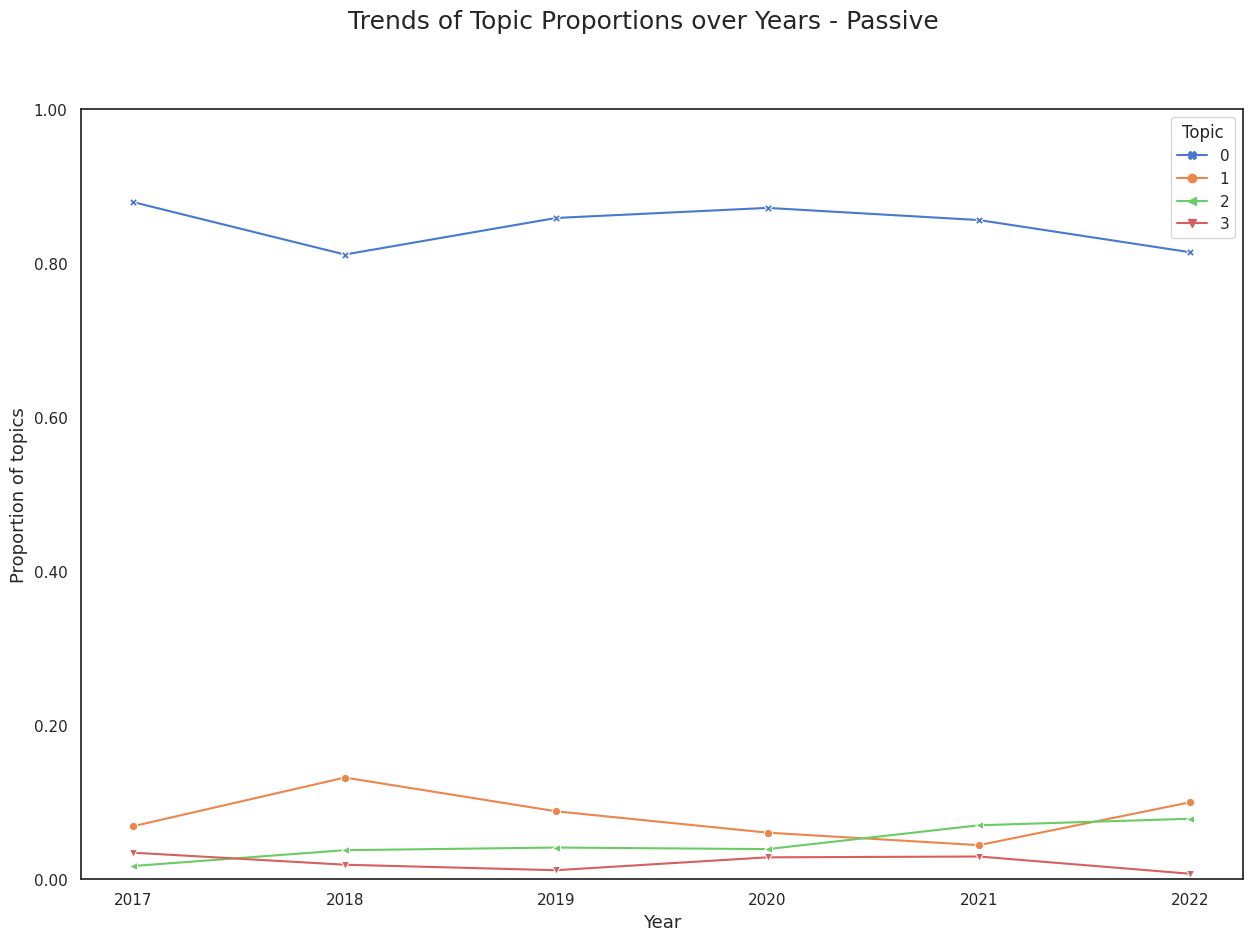

In [281]:
### Plot the trends
# sns.set(rc={'figure.figsize':(15,10)}, style = "white")

# ax = sns.lineplot(data=topic_perc, x ='year', y = 'Ratio',
#                   hue='topic', palette='muted',
#                   legend='full', markers= ["X", "o", "<", "v"],
#                   style = "topic", dashes=False)

# plt.legend(title = "Topic", 
#            #labels=["0", "1", "2", "3"]
#            )

# ax.set_ylabel('Proportion of topics', fontsize = 13)
# ax.set_ylim(0.00, 1) 
# plt.xlabel("Year", fontsize = 13)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.suptitle("Trends of Topic Proportions over Years - Passive", fontsize = 18)
# plt.show()

If we were to simply plot, we would lose most of the interesting details due to the high frequency of Topic 0. So let's 'break' or 'cut-out' the y-axis into two portions - use the top (ax1) for Topic 0, and the bottom (ax2) for the details of the majority of our data

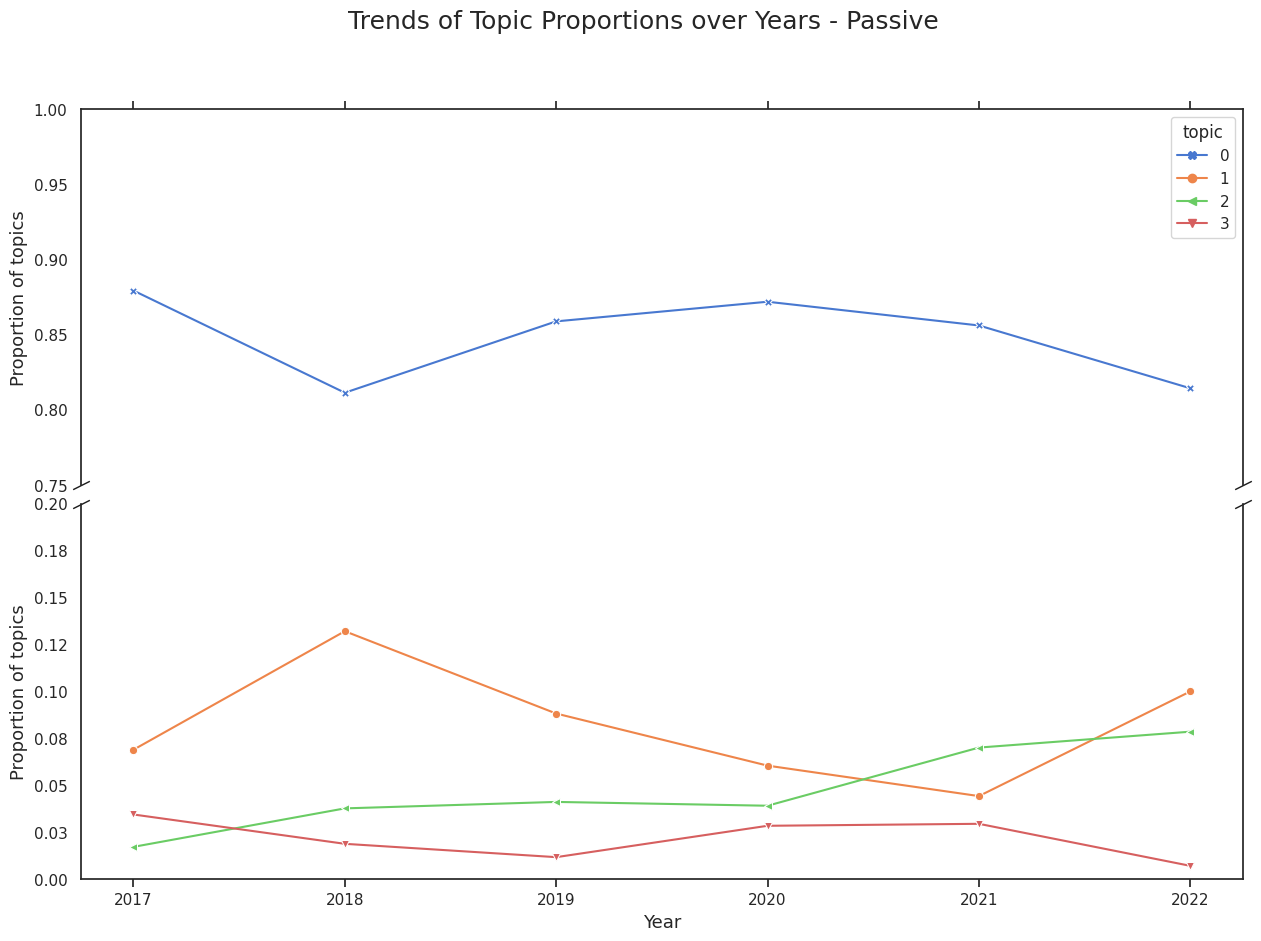

In [283]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (15,10))
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# plot the same data on both axes
sns.lineplot(data=topic_perc, x ='year', y = 'Ratio',
             hue='topic', palette='muted',
             legend='full', markers= ["X", "o", "<", "v"],
             style = "topic", dashes=False, 
             ax=ax1)

sns.lineplot(
    data=topic_perc, x ='year', y = 'Ratio',
    hue='topic', palette='muted',
    legend='full', markers= ["X", "o", "<", "v"],
    style = "topic", dashes=False,
    ax=ax2)

plt.xlabel("Year", fontsize = 13)
ax1.set_ylabel('Proportion of topics', fontsize = 13)
ax2.set_ylabel('Proportion of topics', fontsize = 13)
ax1.set_ylim(.75, 1)  # outliers only
ax2.set_ylim(0.00, .20)  # most of the data
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.get_legend().remove()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.suptitle("Trends of Topic Proportions over Years - Passive", fontsize = 18)
plt.show()

#### by month-year

In [284]:
### Calculate the percentage of each topic for every month and year
topic_perc_ym = topic_over_time.groupby(['topic', 'year-month']).size().groupby(['year-month']).apply(lambda x: (x/x.sum()))
topic_perc_ym

topic  year-month
0      2017-10       1.000000
       2017-11       0.857143
       2017-12       0.857143
       2017-3        1.000000
       2017-4        1.000000
                       ...   
3      2021-12       0.062500
       2021-3        0.032258
       2021-6        0.037037
       2021-8        0.050000
       2022-5        0.045455
Length: 161, dtype: float64

In [285]:
### Ensure the sum of all proportion is 1 for all time points
topic_perc_ym.groupby("year-month").sum()

year-month
2017-10    1.0
2017-11    1.0
2017-12    1.0
2017-3     1.0
2017-4     1.0
2017-5     1.0
2017-6     1.0
2017-7     1.0
2017-8     1.0
2017-9     1.0
2018-1     1.0
2018-10    1.0
2018-11    1.0
2018-12    1.0
2018-2     1.0
2018-3     1.0
2018-4     1.0
2018-5     1.0
2018-6     1.0
2018-7     1.0
2018-8     1.0
2018-9     1.0
2019-1     1.0
2019-10    1.0
2019-11    1.0
2019-12    1.0
2019-2     1.0
2019-3     1.0
2019-4     1.0
2019-5     1.0
2019-6     1.0
2019-7     1.0
2019-8     1.0
2019-9     1.0
2020-1     1.0
2020-10    1.0
2020-11    1.0
2020-12    1.0
2020-2     1.0
2020-3     1.0
2020-4     1.0
2020-5     1.0
2020-6     1.0
2020-7     1.0
2020-8     1.0
2020-9     1.0
2021-1     1.0
2021-10    1.0
2021-11    1.0
2021-12    1.0
2021-2     1.0
2021-3     1.0
2021-4     1.0
2021-5     1.0
2021-6     1.0
2021-7     1.0
2021-8     1.0
2021-9     1.0
2022-1     1.0
2022-2     1.0
2022-3     1.0
2022-4     1.0
2022-5     1.0
2022-6     1.0
2022-7     1.0
2022-8     1.0

In [286]:
### Reset index and rename columns
topic_perc_ym = pd.DataFrame(topic_perc_ym).reset_index().rename(columns={0: "Ratio"})

In [287]:
### Change the format of the time point
topic_perc_ym['year-month'] = pd.to_datetime(topic_perc_ym['year-month']).dt.strftime('%Y-%m')

In [288]:
### Sort by time
topic_perc_ym = topic_perc_ym.sort_values(by = ["year-month"])
topic_perc_ym

,topic,year-month,Ratio
3,0,2017-03,1.000000
4,0,2017-04,1.000000
5,0,2017-05,0.875000
67,1,2017-05,0.125000
68,1,2017-06,0.111111
...,...,...,...
108,1,2022-06,0.076923
63,0,2022-06,0.923077
64,0,2022-07,1.000000
65,0,2022-08,0.785714


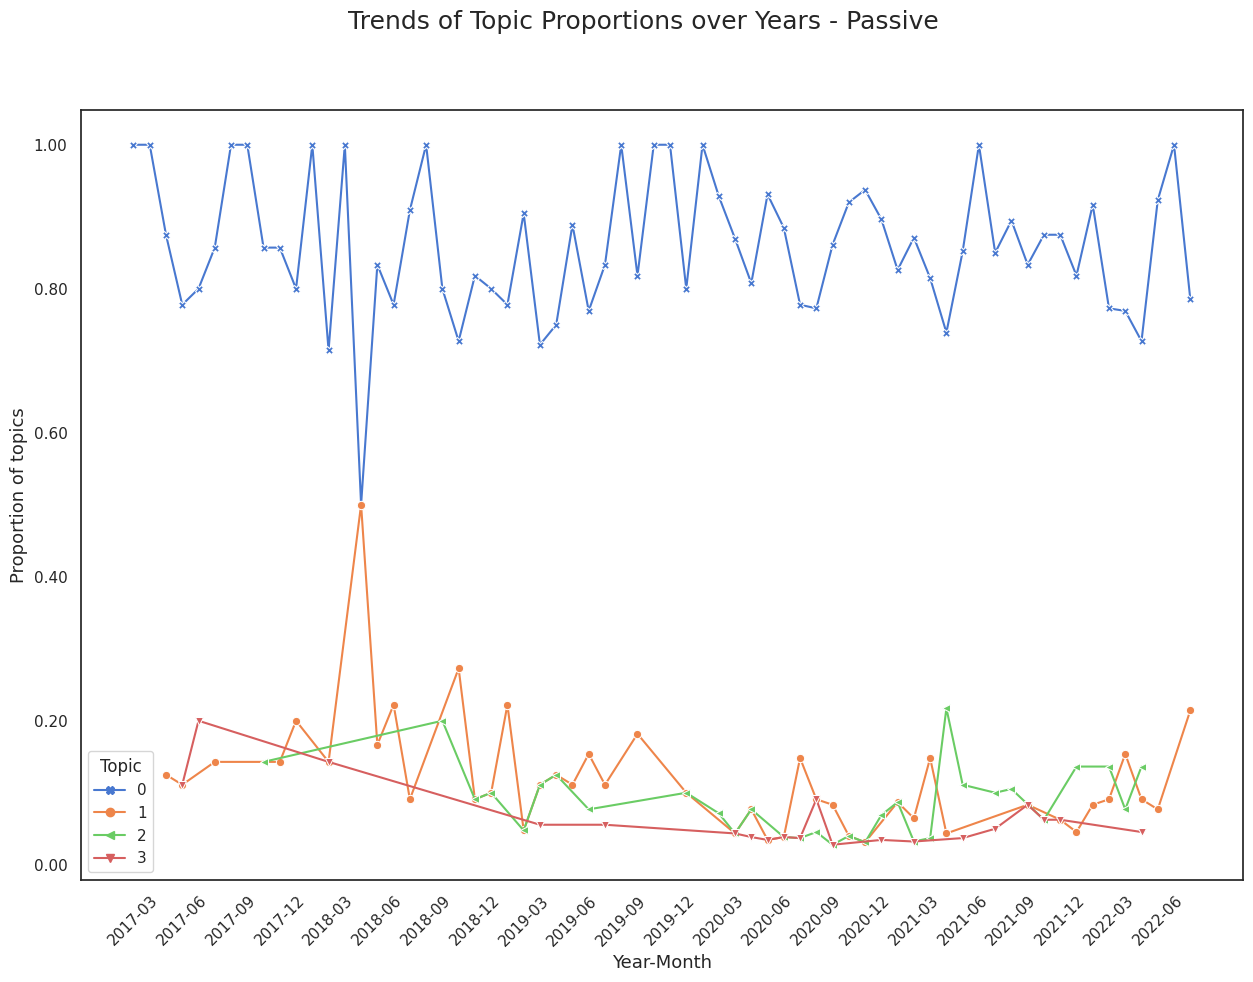

In [295]:
### Plot the trends
sns.set(rc={'figure.figsize':(15,10)}, style = "white")

ax = sns.lineplot(data=topic_perc_ym, x ='year-month', y = 'Ratio',
                  hue='topic', palette='muted',
                  legend='full', markers= ["X", "o","<", "v"],
                  style = "topic", dashes=False)

plt.legend(title = "Topic", 
           #labels=["0", "1", "2", "3"]
           )

ax.set_ylabel('Proportion of topics', fontsize = 13)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=3))
plt.xticks(rotation=45)
plt.xlabel("Year-Month", fontsize = 13)
plt.suptitle("Trends of Topic Proportions over Years - Passive", fontsize = 18)
plt.show()